# Modelos de Deep Learning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv", thousands=',', decimal='.')
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.sort_index(inplace=True)

df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%
...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%
2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%
2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%


In [4]:
# retorno acumulado
def retorno_acumulado(df, columna):
    retorno_diario = (df[columna].diff() / df[columna].shift(1))
    return retorno_diario.cumsum()

def volatilidad(retorno_acum, ventana):
    std_w = retorno_acum.rolling(window=ventana).std()
    return std_w


df["DailyReturn"] = retorno_acumulado(df, "Price")
df["Volatility"] =  volatilidad(df["DailyReturn"], 7)

df

,Price,Open,High,Low,Vol.,Change %,DailyReturn,Volatility
Date,,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,NaN,NaN
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.000000,NaN
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.000000,NaN
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.000000,NaN
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.000000,NaN
...,...,...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%,23.719802,0.043620
2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%,23.685166,0.036828
2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%,23.658934,0.034760


In [5]:
timeserie  = df["Price"]

## Split de datos

In [119]:
def split_time_series(data, tau, train_nrows, train_ncols):
    """
    train_ncols: Número de columnas para el train
    train_nrows: Número de filas para el train
    tau: número de rows y cols para val y test
    """
    n_samples = len(data)
    
    total_dim = train_nrows + tau * 2 # total filas por dim

    splits = []
    id_counter = 1
    dim = 1
    split_counter = 0

    for start in range(0, n_samples - total_dim):
        if split_counter == 0:
            if start + total_dim > n_samples:
                break  # No hay suficientes datos

        x_train_end = start + train_nrows
        y_end = x_train_end + 1

        if split_counter < train_nrows:
            split_type  = "train"
        elif split_counter < train_nrows + tau:
            split_type  = "val"
        elif split_counter < train_nrows + tau*2:
            split_type  = "test"
        else:
            dim += 1
            split_counter = 0
            split_type = "train"
        
        split_dict = {
            "id": id_counter,
            "dim": dim,
            "split": split_type,
            "X": [data.iloc[start:x_train_end]],  
            "y": [data.iloc[x_train_end:y_end]]
        }

        splits.append(split_dict)

        # Incrementar los contadores
        id_counter += 1
        split_counter += 1

        if split_counter >= total_dim:
            dim += 1
            split_counter = 0

    return splits

array = split_time_series(data=timeserie, tau=7, train_nrows=14, train_ncols=2)
df_model = pd.DataFrame(array)
df_model.iloc[-30:]

,id,dim,split,X,y
4941,4942,177,train,"[[42120.9, 42030.7, 43299.8, 42946.2, 42580.5,...",[[47758.2]]
4942,4943,177,val,"[[42030.7, 43299.8, 42946.2, 42580.5, 43081.4,...",[[48277.3]]
4943,4944,177,val,"[[43299.8, 42946.2, 42580.5, 43081.4, 43194.7,...",[[49941.3]]
4944,4945,177,val,"[[42946.2, 42580.5, 43081.4, 43194.7, 43005.7,...",[[49716.0]]
4945,4946,177,val,"[[42580.5, 43081.4, 43194.7, 43005.7, 42581.4,...",[[51782.4]]
4946,4947,177,val,"[[43081.4, 43194.7, 43005.7, 42581.4, 42697.2,...",[[51901.3]]
4947,4948,177,val,"[[43194.7, 43005.7, 42581.4, 42697.2, 43087.7,...",[[52134.2]]
4948,4949,177,val,"[[43005.7, 42581.4, 42697.2, 43087.7, 44339.8,...",[[51646.0]]
4949,4950,177,test,"[[42581.4, 42697.2, 43087.7, 44339.8, 45293.3,...",[[52117.5]]
4950,4951,177,test,"[[42697.2, 43087.7, 44339.8, 45293.3, 47127.5,...",[[51783.6]]


,id,dim,split,X,y
4953,4954,310,train,"[[45293.3, 47127.5, 47758.2, 48277.3, 49941.3,...",[[51320.4]]
4954,4955,310,train,"[[47127.5, 47758.2, 48277.3, 49941.3, 49716.0,...",[[50740.5]]
4955,4956,310,train,"[[47758.2, 48277.3, 49941.3, 49716.0, 51782.4,...",[[51571.6]]
4956,4957,310,train,"[[48277.3, 49941.3, 49716.0, 51782.4, 51901.3,...",[[51722.7]]
4957,4958,310,train,"[[49941.3, 49716.0, 51782.4, 51901.3, 52134.2,...",[[54495.1]]
4958,4959,310,val,"[[49716.0, 51782.4, 51901.3, 52134.2, 51646.0,...",[[57056.2]]
4959,4960,310,test,"[[51782.4, 51901.3, 52134.2, 51646.0, 52117.5,...",[[62467.6]]
4960,4961,311,train,"[[51901.3, 52134.2, 51646.0, 52117.5, 51783.6,...",[[61169.3]]
4961,4962,311,train,"[[52134.2, 51646.0, 52117.5, 51783.6, 52263.5,...",[[62397.7]]
4962,4963,311,train,"[[51646.0, 52117.5, 51783.6, 52263.5, 51858.2,...",[[61994.5]]


In [105]:
df_model.iloc[:30]

,id,dim,split,X,y
0,1,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
1,2,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
2,3,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
3,4,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
4,5,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
5,6,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
6,7,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
7,8,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
8,9,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]
9,10,1,train,"[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...",[[0.1]]


In [121]:
def split_time_series(data, tau, train_nrows, train_ncols):
    """
    train_ncols: Número de columnas para el train
    train_nrows: Número de filas para el train
    tau: número de rows y cols para val y test
    """
    n_samples = len(data)
    
    dim_tau_size = tau  # cantidad de días y filas para val y test
    len_dim = train_nrows + dim_tau_size * 2  # total filas por dim

    splits = []
    id_counter = 1
    dim = 1
    split_counter = 0

    for start in range(n_samples):
        if split_counter == 0:
            if start + len_dim > n_samples:
                break  # No hay suficientes datos

        row_train_end = start + train_nrows
        y_end = row_train_end + 1

        # Determinar el tipo de split
        if split_counter < train_nrows:
            split_type = "train"
            X_data = data.iloc[start:row_train_end].values.copy()  # Tomar train_ncols columnas
            y_data = data.iloc[start:row_train_end].values.copy()  # y correspondiente a train_nrows
        elif split_counter < train_nrows + dim_tau_size:
            split_type = "val"
            X_data = data.iloc[row_train_end:row_train_end + tau].values.copy()  # val: tau columnas
            y_data = data.iloc[y_end:y_end + tau].values.copy()  # y correspondiente al tau
        elif split_counter < train_nrows + dim_tau_size * 2:
            split_type = "test"
            X_data = data.iloc[y_end:y_end + dim_tau_size].values.copy()  # test: tau columnas
            y_data = data.iloc[y_end + tau:y_end + tau + tau].values.copy()  # y correspondiente al tau
        else:
            dim += 1
            split_counter = 0
            split_type = "train"
            continue  # Saltar al siguiente ciclo

        split_dict = {
            "id": id_counter,
            "dim": dim,
            "split": split_type,
            "X": X_data,
            "y": y_data
        }

        splits.append(split_dict)

        # Contadores
        id_counter += 1
        split_counter += 1

        if split_counter >= len_dim:
            dim += 1
            split_counter = 0

    return splits

array = split_time_series(data=timeserie, tau=3, train_nrows=14, train_ncols=1)
df_model = pd.DataFrame(array)
df_model.iloc[-30:]

IndexingError: Too many indexers

In [8]:
## PENDIENTE
def plot_splits(data, splits, horizon, dim=1):
    return 1

## Entrenamiento y validación

In [55]:
import keras.backend as K
import statsmodels.api as sm
import tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
devices = tf.config.list_physical_devices()
print("Available devices:")
for device in devices:
    print(device)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using GPU.")
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU details: {gpu_details}")
else:
    print("TensorFlow is not using GPU.")

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using GPU.
GPU details: {'device_name': 'NVIDIA GeForce RTX 2060 SUPER', 'compute_capability': (7, 5)}


In [11]:
dim = 60

df_dim = df_model.loc[df_model["dim"] == dim]

split = "train"
X_train, y_train = df_dim.loc[df_dim["split"] == split, "X"].tolist(), df_dim.loc[df_dim["split"] == split, "y"].tolist()
X_train, y_train = np.array([np.array(xi).flatten() for xi in X_train]), np.array([np.array(yi).flatten() for yi in y_train])


split = "val"
X_val, y_val = df_dim.loc[df_dim["split"] == split, "X"].tolist(), df_dim.loc[df_dim["split"] == split, "y"].tolist()
X_val, y_val = np.array([np.array(xi).flatten() for xi in X_val]), np.array([np.array(yi).flatten() for yi in y_val])

split = "test"
X_test, y_test = df_dim.loc[df_dim["split"] == split, "X"].tolist(), df_dim.loc[df_dim["split"] == split, "y"].tolist()
X_test, y_test = np.array([np.array(xi).flatten() for xi in X_test]), np.array([np.array(yi).flatten() for yi in y_test])

# Re-dimensionar los datos para RNN/LSTM
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_rnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


#pendiente llevarlo a función
def get_batch(df, dim):
    dim_df = df_model.loc[df_model["dim"] == 100]

    # return X_train, y_train, X_val, y_val

X_train

array([[252.1, 269.2, 263.3, 236.2, 234. , 231.8, 218.5],
       [269.2, 263.3, 236.2, 234. , 231.8, 218.5, 225.3],
       [263.3, 236.2, 234. , 231.8, 218.5, 225.3, 238.9],
       [236.2, 234. , 231.8, 218.5, 225.3, 238.9, 227.4],
       [234. , 231.8, 218.5, 225.3, 238.9, 227.4, 226.6],
       [231.8, 218.5, 225.3, 238.9, 227.4, 226.6, 216.5],
       [218.5, 225.3, 238.9, 227.4, 226.6, 216.5, 223. ],
       [225.3, 238.9, 227.4, 226.6, 216.5, 223. , 227.7],
       [238.9, 227.4, 226.6, 216.5, 223. , 227.7, 223.7],
       [227.4, 226.6, 216.5, 223. , 227.7, 223.7, 220.3],
       [226.6, 216.5, 223. , 227.7, 223.7, 220.3, 219.7],
       [216.5, 223. , 227.7, 223.7, 220.3, 219.7, 218.8],
       [223. , 227.7, 223.7, 220.3, 219.7, 218.8, 221.8],
       [227.7, 223.7, 220.3, 219.7, 218.8, 221.8, 236.2]])

In [23]:
def calculate_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    metrics = {
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse,
        "MSE": rmse**2,
        "R2": r2_score(y_true, y_pred)
    }
    return metrics

# Metricas adicionales para los modelos:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2_metric(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_and_train_model(model_type, neurons, dropout_rate, batch_size, X_train, y_train, X_val, y_val):

    model = Sequential()
    if model_type == 'MLP':
        # (samples, features)
        model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'RNN':
        #(samples, timesteps, features)
        model.add(SimpleRNN(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'LSTM':
        #(samples, timesteps, features)
        model.add(LSTM(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    else:
        raise ValueError("Modeo inválido")

    model.compile(optimizer=Adam(), loss='mse', metrics=['mape','mae', 'mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'models/best_model_{model_type}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=0,
                        callbacks=[early_stopping, model_checkpoint])
    return model, history

In [24]:
model_type = 'MLP'
neurons = 1000
dropout_rate = 0.2
batch_size = 16

model_mlp, history_mlp = create_and_train_model(model_type, neurons, dropout_rate, batch_size,
                                                X_train, y_train, X_val, y_val)


In [25]:
model_type = 'RNN'
model_rnn, history_rnn = create_and_train_model(model_type, neurons, dropout_rate, batch_size,
                                                X_train_rnn, y_train, X_val_rnn, y_val)

In [26]:
model_type = 'LSTM'
model_lstm, history_lstm = create_and_train_model(model_type, neurons, dropout_rate, batch_size,
                                                  X_train_rnn, y_train, X_val_rnn, y_val)

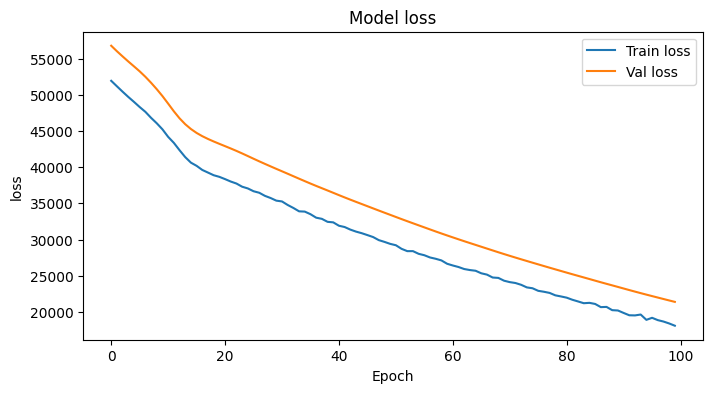

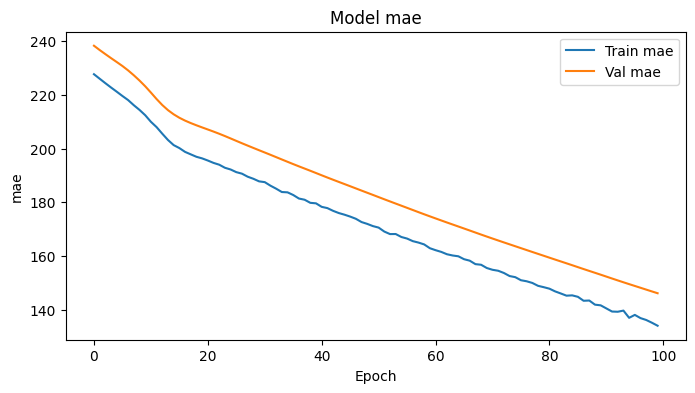

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Métricas disponibles en history.history
    metrics = ['loss', 'mae']
    for metric in metrics:
        plt.figure(figsize=(8, 4))
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

# Ejemplo para el modelo LSTM
plot_training_history(history_lstm)


In [35]:
# Seleccionar el modelo y los datos correspondientes
#model = model_rnn  # o model_mlp, model_rnn
model_type == 'RNN'
model = load_model('models/best_model_RNN.h5')

# Metricas con train
X_train_model = X_train if model_type == 'MLP' else X_train_rnn
y_train_pred = model.predict(X_train_model)
y_train_true = y_train
metricas_train = calculate_metrics(y_train_true, y_train_pred)
resid_train = y_train_true - y_train_pred

# Metricas con test
X_test_model = X_test if model_type == 'MLP' else X_test_rnn
y_test_pred = model.predict(X_test_model)
y_test_true = y_test
metricas_test = calculate_metrics(y_test_true, y_test_pred)
resid_test = y_test_true - y_test_pred

print("Resultados de las métricas de entrenamiento:")
for metric_name, metric_value in metricas_train.items():
    print(f"{metric_name}: {metric_value}")

print("---------------------------------------------")
print("Resultados de las métricas de prueba:")
for metric_name, metric_value in metricas_test.items():
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 21ms/step
Resultados de las métricas de entrenamiento:
MAPE: 0.5354985268720538
MAE: 122.01694706508091
RMSE: 122.47127561908457
MSE: 14999.213351765777
R2: -134.03314764288612
---------------------------------------------
Resultados de las métricas de prueba:
MAPE: 0.5640689966039575
MAE: 136.66693725585938
RMSE: 136.87085189862515
MSE: 18733.63009945538
R2: -334.8583442023878


In [45]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Prueba de Ljung-Box
ljung_box_test = acorr_ljungbox(resid_train, lags=[10], return_df=True)
ljung_box_p_value = ljung_box_test['lb_pvalue'].values[0]  # Obtener el p-valor
ljung_box_p_value

0.6395098583405932

In [48]:
from scipy import stats

# Prueba de Jarque-Bera
jb_test = stats.jarque_bera(resid_train)
jarque_bera_p_value = jb_test[1]
jarque_bera_p_value

0.0027739517297854766

In [49]:
results_df = pd.DataFrame({
    "MAPE": [metricas_train['MAPE']],
    "MAE": [metricas_train['MAE']],
    "RMSE": [metricas_train['RMSE']],
    "MSE": [metricas_train['MSE']],
    "R2": [metricas_train['R2']],
    "Ljung-Box test (p-value)": [ljung_box_p_value],
    "Jarque-Bera (p-value)": [jarque_bera_p_value]
})

In [50]:
results_df

,MAPE,MAE,RMSE,MSE,R2,Ljung-Box test (p-value),Jarque-Bera (p-value)
0,0.535499,122.016947,122.471276,14999.213352,-134.033148,0.63951,0.002774


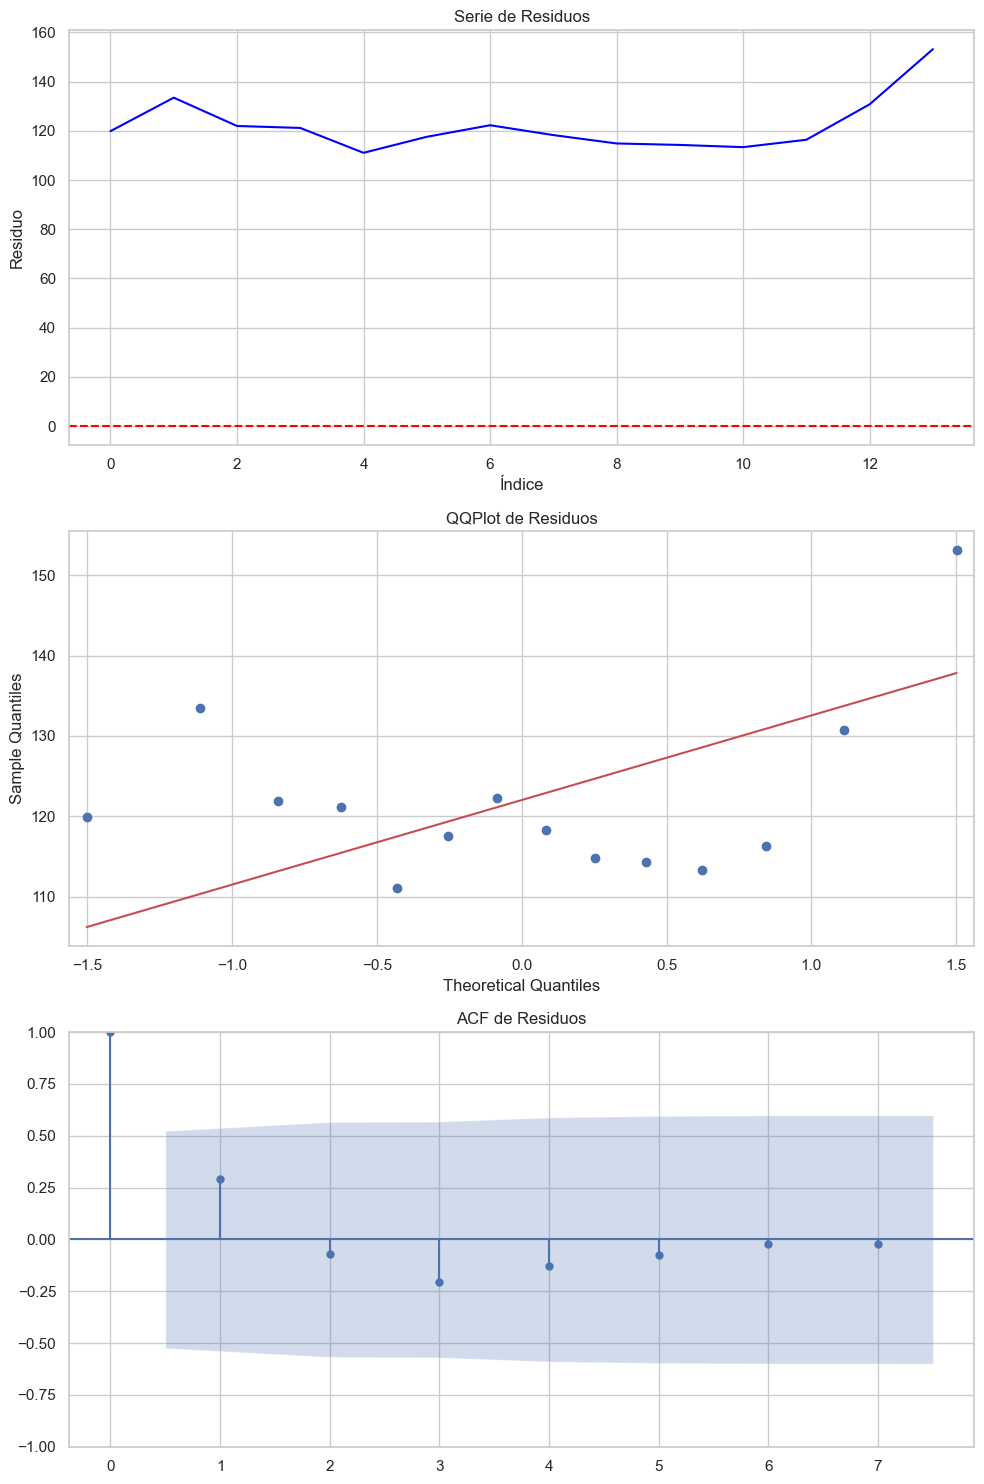

In [57]:

def plot_residuals(resid):
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    # Gráfica de la Serie de Residuos
    axs[0].plot(resid, color='blue')
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('Serie de Residuos')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Residuo')

    # Gráfica QQPlot
    sm.qqplot(resid, line='s', ax=axs[1])
    axs[1].set_title('QQPlot de Residuos')

    # Gráfica ACF de Residuos
    plot_acf(resid, ax=axs[2])
    axs[2].set_title('ACF de Residuos')

    # Ajustar el layout
    plt.tight_layout()
    plt.show()

# Uso de la función con los residuos calculados
plot_residuals(resid_train)

In [17]:


tau_list = 7, 14 , 21, 28
train_window = 7, 14 , 21, 28

# Hiperparámetros a explorar
dropout_rates = [0.2, 0.4, 0.6, 0.8]
neurons_list = [10, 100, 1000, 10000]
batch_sizes = [16, 32, 64, 128]

results = []

